# **TimeGan Based Simulator**
***

### Overview 

1. **Load Data**: Reads the consolidated sensor data from a CSV file.  
2. **Preprocess Data**: Handles missing values, normalizes data, and ensures consistent 30-second intervals.  
3. **Visualize Trends**: Plots time-series data for cooling, maxigauge, and temperature to identify patterns and anomalies.  
4. **Feature Extraction**: Computes statistical metrics (mean, std, min, max) and checks data stationarity using the ADF test.  
5. **Prepare Training Data**: Constructs time-series sequences with a chosen window size (e.g., 60 timestamps).  
6. **Build TimeGAN**: Implements an LSTM-based generator and an RNN-based discriminator to learn temporal dependencies.  
7. **Train Model**: Optimizes the TimeGAN framework using adversarial learning to generate realistic synthetic time-series data.  
8. **Evaluate Results**: Assesses the quality of generated sequences by comparing them with real sensor data using statistical and visual methods.  
9. **Generate Synthetic Data**: Uses the trained TimeGAN model to produce new sensor readings that maintain the original data's statistical properties.  
10. **Visualization**: Plots real vs. synthetic data to validate the effectiveness of the model.  
---

### Step 1: Import Required Libraries

In [1]:
# Install dependencies
%pip install numpy pandas matplotlib seaborn tensorflow scikit-learn statsmodels

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
    --------------------------------------- 5.8/376.0 MB 27.1 MB/s eta 0:00:14
   - -------------------------------------- 12.6/376.0 MB 29.3 MB/s eta 0:00:13
   - -------------------------------------- 16.8/376.0 MB 31.1 MB/s eta 0:00:12
   - -------------------------------------- 18.1/376.0 MB 21.1 MB/s eta 0:00:17
   -- ------------------------------------- 19.9/376.0 MB 22.1 MB/s eta 0:00:17
   -- ------------------------------------- 25.2/376.0 MB 19.7 MB/s eta 0:00:18
   --- ------------------------------------ 34.9/376.0 MB 23.6 MB/s eta 0:00:15
   ---- ----------------------------------- 45.9/376.0 MB 27.0 MB/s eta 0:00:13
   ------ --------------------------------- 58.2/376.0 MB 30.4 MB/s eta 0:00:11
   ------- -------------------------------- 72.1/376.0 MB 34.1 MB/s eta 0:00:09
   ------- -------------------------------- 74.4/376.0 MB 34.7 MB/s eta 0:00:09
   -------- ------------------------------- 77.1/3

In [2]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

***
### Step 2: Load and Preprocess Data
- Loading the consolidated CSV file.
- Handling missing values.
- Normalizing the data for better model performance.

In [2]:
# Load the dataset
data = pd.read_csv("../databases/processed_data/cd230831.csv")

# Convert the datetime column to a proper datetime format if needed
data['datetime'] = pd.to_datetime(data['datetime'])


# Display the first few rows to inspect the structure
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
             datetime  cooling_channel0  cooling_channel1  cooling_channel10  \
0 2023-08-31 00:00:30         15.596670         15.558330          15.542780   
1 2023-08-31 00:01:00         15.594503         15.558330          15.538204   
2 2023-08-31 00:01:30         15.592003         15.558330          15.532924   
3 2023-08-31 00:02:00         15.590465         15.553758          15.537758   
4 2023-08-31 00:02:30         15.589075         15.548483          15.544148   

   cooling_channel11  maxigauge_channel1  maxigauge_channel2  \
0          15.555560                0.02            0.088700   
1          15.546651                0.02            0.088713   
2          15.536371                0.02            0.088762   
3          15.549443                0.02            0.088800   
4          15.566108                0.02            0.088800   

   maxigauge_channel3  maxigauge_channel4  maxigauge_channel5  \
0           -1.480000               15

In [3]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply Z-score normalization (excluding the datetime column)
scaled_data = scaler.fit_transform(data.iloc[:, 1:])

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])
scaled_df.insert(0, 'datetime', data['datetime'])  # Reinsert datetime column

# Display summary statistics after standardization
print("\nSummary Statistics after Standardization:")
print(scaled_df.describe())

# Save the preprocessed data for future use
# scaled_df.to_csv("../databases/processed_data/TimeGAN_data.csv", index=False)
print("\nData standardization completed successfully. Saved as 'TimeGAN_data.csv'.")


Summary Statistics after Standardization:
                            datetime  cooling_channel0  cooling_channel1  \
count                          69112      6.911200e+04      6.911200e+04   
mean   2023-09-11 23:58:15.000000256      8.159028e-16      1.158056e-15   
min              2023-08-31 00:00:30     -3.214294e+00     -3.056965e+00   
25%       2023-09-05 23:59:22.500000      2.029070e-02     -1.656629e-01   
50%              2023-09-11 23:58:15      3.129120e-01      1.632958e-01   
75%       2023-09-17 23:57:07.500000      4.129965e-01      5.470944e-01   
max              2023-09-23 23:56:00      1.231259e+00      2.625233e+00   
std                              NaN      1.000007e+00      1.000007e+00   

       cooling_channel10  cooling_channel11  maxigauge_channel1  \
count       6.911200e+04       6.911200e+04        6.910900e+04   
mean       -6.316667e-16      -3.053055e-15        2.673185e-18   
min        -3.228404e+00      -3.096646e+00       -1.827294e-02   
25% 

In [4]:
scaled_df.head()

,datetime,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
0,2023-08-31 00:00:30,-3.199849,-2.994182,-3.204761,-3.034381,-0.016913,-0.045074,-2.155074,-2.763639,2.137367,6.126256,3.608761,3.889064,3.756615,-0.187381
1,2023-08-31 00:01:00,-3.200409,-2.994182,-3.206055,-3.042871,-0.016913,-0.045073,-2.155055,-2.763639,2.137367,6.126256,3.608762,3.889064,3.756610,-0.187381
2,2023-08-31 00:01:30,-3.201056,-2.994182,-3.207548,-3.052668,-0.016913,-0.045070,-2.154981,-2.763639,2.137367,6.126256,3.608777,3.889071,3.756455,-0.187381
3,2023-08-31 00:02:00,-3.201453,-2.998553,-3.206181,-3.040210,-0.016913,-0.045067,-2.154925,-2.763639,2.137367,6.126256,3.608791,3.889081,3.756316,-0.187381
4,2023-08-31 00:02:30,-3.201812,-3.003597,-3.204374,-3.024329,-0.016913,-0.045067,-2.154925,-2.763639,2.137367,6.126256,3.608769,3.889145,3.756620,-0.187381


### Step 3: Data Visualization
- Plot time-series trends for cooling, maxigauge, and temperature sensors.
- Identify any existing patterns or outliers in the dataset.
- Check if the standardization process was correctly applied.

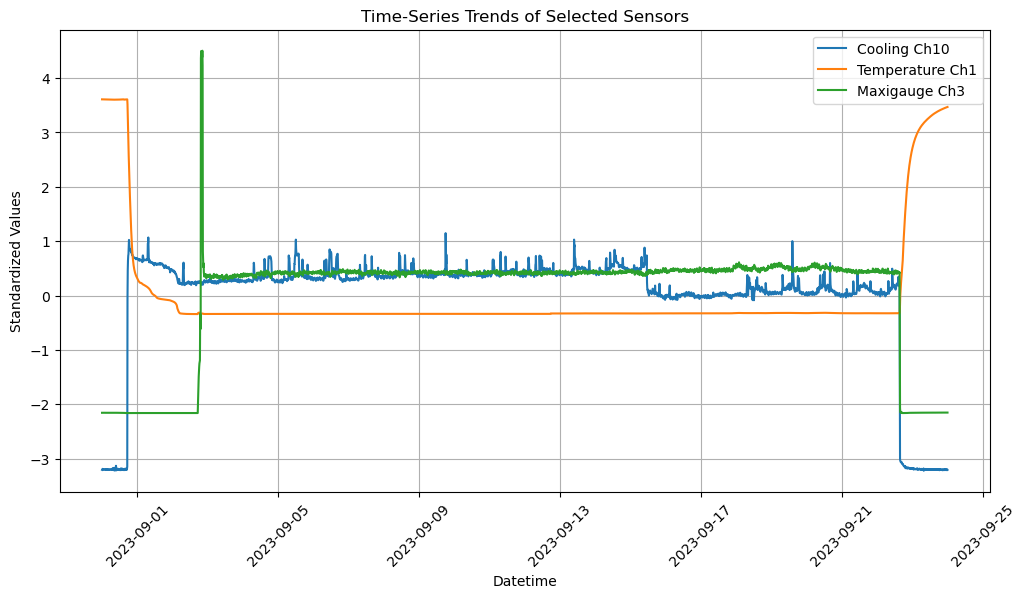

In [5]:
# Load the preprocessed dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select the chosen sensor channels
selected_columns = ['datetime', 'cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
subset_data = data[selected_columns]

# Downsample data (take one point every 10 minutes)
subset_downsampled = subset_data.iloc[::20, :]  # Select every 20th row (~10 min interval)

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the selected sensor data over time
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['cooling_channel10'], label='Cooling Ch10')
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['temperature_channel1'], label='Temperature Ch1')
sns.lineplot(x=subset_downsampled['datetime'], y=subset_downsampled['maxigauge_channel3'], label='Maxigauge Ch3')

# Formatting the plot
plt.xlabel("Datetime")
plt.ylabel("Standardized Values")
plt.title("Time-Series Trends of Selected Sensors")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Step 4: Feature Extraction
extract key statistical features from the dataset.

In [6]:
'''# Replace Inf values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values using forward-fill (or use mean imputation)
data.fillna(method='ffill', inplace=True)  # Forward-fill
data.fillna(method='bfill', inplace=True)  # Backward-fill (if needed)

# Drop any remaining NaN rows
data.dropna(inplace=True)

# Save the cleaned dataset (optional)
data.to_csv("../databases/processed_data/TimeGAN_data_cleaned.csv", index=False)

print("\n Data cleaned successfully. No NaN or Inf values remain.")'''

'# Replace Inf values with NaN\ndata.replace([np.inf, -np.inf], np.nan, inplace=True)\n\n# Fill NaN values using forward-fill (or use mean imputation)\ndata.fillna(method=\'ffill\', inplace=True)  # Forward-fill\ndata.fillna(method=\'bfill\', inplace=True)  # Backward-fill (if needed)\n\n# Drop any remaining NaN rows\ndata.dropna(inplace=True)\n\n# Save the cleaned dataset (optional)\ndata.to_csv("../databases/processed_data/TimeGAN_data_cleaned.csv", index=False)\n\nprint("\n Data cleaned successfully. No NaN or Inf values remain.")'

In [7]:
from statsmodels.tsa.stattools import adfuller

# Load the dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select only the relevant sensor columns
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns]

# Check for NaN and Inf values before ADF test
sensor_data.replace([np.inf, -np.inf], np.nan, inplace=True)
sensor_data.fillna(method='ffill', inplace=True)  # Forward-fill missing values
sensor_data.fillna(method='bfill', inplace=True)  # Backward-fill if needed
sensor_data.dropna(inplace=True)  # Drop any remaining NaN values

# Perform ADF test for selected sensors
adf_results = {}
for column in sensor_data.columns:
    adf_test = adfuller(sensor_data[column])
    adf_results[column] = {'ADF Statistic': adf_test[0], 'p-value': adf_test[1]}

# Convert ADF results to a DataFrame
adf_df = pd.DataFrame.from_dict(adf_results, orient='index')

# Display ADF test results
print("\nAugmented Dickey-Fuller (ADF) Test Results for Selected Sensors:")
print(adf_df)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_443892\1340927989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_443892\1340927989.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sensor_data.fillna(method='ffill', inplace=True)  # Forward-fill missing values
C:\Users\Administrator\AppData\Local\Temp\ipykernel_443892\1340927989.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data.fillna(metho


Augmented Dickey-Fuller (ADF) Test Results for Selected Sensors:
                      ADF Statistic   p-value
cooling_channel10         -2.762297  0.063865
temperature_channel1      -2.635902  0.085802
maxigauge_channel3        -3.553566  0.006713


### Step 5: Prepare Training Data for TimeGAN
- Select 'cooling_channel10', 'temperature_channel1', and 'maxigauge_channel3' for training.
- Convert the dataset into sequences that TimeGAN can process.
- Define the time window (sequence length) for training.

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense

# Load dataset
data = pd.read_csv("../databases/processed_data/TimeGAN_data.csv")

# Convert datetime column to proper format
data['datetime'] = pd.to_datetime(data['datetime'])

# Select relevant sensor columns for training
selected_columns = ['cooling_channel10', 'temperature_channel1', 'maxigauge_channel3']
sensor_data = data[selected_columns].values  # Convert to numpy array

# Define sequence length (e.g., 60 time steps = 30 minutes)
sequence_length = 60

# Function to create overlapping sequences for TimeGAN training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i: i + seq_length])
    return np.array(sequences)

# Create training sequences
train_data = create_sequences(sensor_data, sequence_length)

# Check the shape of the prepared training data
print("\n✅ Training data prepared successfully!")
print(f"Training data shape: {train_data.shape}")  # Expected output: (num_samples, sequence_length, num_features)

# Define batch size and training epochs
batch_size = 32
epochs = 10


✅ Training data prepared successfully!
Training data shape: (69052, 60, 3)


### Step 6: Implement TimeGAN (LSTM Generator + RNN Discriminator)
- LSTM-based Generator
- RNN-based Discriminator
- Embedding & Recovery Networks

In [9]:
def build_generator():
    inputs = Input(shape=(60, 3))  # 60 个时间步，3 个通道
    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(32, return_sequences=True)(x)
    outputs = Dense(3, activation='tanh')(x)  # 确保输出形状一致
    return Model(inputs, outputs, name="Generator")

generator = build_generator()
print("\n✅ Generator Model Summary:")
generator.summary()


✅ Generator Model Summary:


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60, 3)          │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,923 (116.89 KB)

 Trainable params: 29,923 (116.89 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Flatten

def build_discriminator():
    inputs = Input(shape=(60, 3))  # 输入形状: (batch_size, 60, 3)
    x = GRU(64, return_sequences=False)(inputs)  # 确保只输出 (batch_size, 64)
    x = Dense(32, activation='relu')(x)  # 降维
    outputs = Dense(1, activation='sigmoid')(x)  # 确保最终输出 (batch_size, 1)
    return Model(inputs, outputs, name="Discriminator")

discriminator = build_discriminator()
print("\n✅ Discriminator Model Summary:")
discriminator.summary()


✅ Discriminator Model Summary:


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,361 (60.00 KB)

 Trainable params: 15,361 (60.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Convert train data to NumPy array
train_data = np.array(train_data)  # (num_samples, 60, 3)

# 取一个 batch 的真实数据
real_sequences = train_data[:batch_size]  # (batch_size, 60, 3)

# 生成假数据
fake_sequences = generator.predict(real_sequences, verbose=0)

# 让 Discriminator 进行预测
real_output = discriminator.predict(real_sequences, verbose=0)
fake_output = discriminator.predict(fake_sequences, verbose=0)

print(f"\n✅ Shape of real_sequences: {real_sequences.shape}")  # (batch_size, 60, 3)
print(f"✅ Shape of fake_sequences: {fake_sequences.shape}")  # (batch_size, 60, 3)
print(f"✅ Shape of real_output from Discriminator: {real_output.shape}")  # 预期应为 (batch_size, 1)
print(f"✅ Shape of fake_output from Discriminator: {fake_output.shape}")  # 预期应为 (batch_size, 1)



✅ Shape of real_sequences: (32, 60, 3)
✅ Shape of fake_sequences: (32, 60, 3)
✅ Shape of real_output from Discriminator: (32, 1)
✅ Shape of fake_output from Discriminator: (32, 1)


In [12]:
'''# 定义优化器
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# 编译 Generator 和 Discriminator
generator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)
discriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)'''

"# 定义优化器\ngen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\ndisc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)\n\n# 编译 Generator 和 Discriminator\ngenerator.compile(loss='binary_crossentropy', optimizer=gen_optimizer)\ndiscriminator.compile(loss='binary_crossentropy', optimizer=disc_optimizer)"

### Step 7: Train TimeGAN (Small Training Setup)

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense

# ... [数据加载和预处理部分保持不变] ...

# 定义优化器（保持原样）
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)

# 移除生成器和判别器的编译步骤（重要修改）
# generator.compile(...) 和 discriminator.compile(...) 全部删除

# 准备标签（保持原样）
real_labels = np.ones((batch_size, 1), dtype=np.float32)
fake_labels = np.zeros((batch_size, 1), dtype=np.float32)

# 修改后的训练循环（使用GradientTape）
for epoch in range(epochs):
    for i in range(0, len(train_data) - batch_size, batch_size):
        real_sequences = train_data[i:i + batch_size]
        
        # 训练判别器
        with tf.GradientTape() as disc_tape:
            # 生成假数据
            fake_sequences = generator(real_sequences, training=False)
            
            # 判别器对真实和假数据的预测
            d_real = discriminator(real_sequences, training=True)
            d_fake = discriminator(fake_sequences, training=True)
            
            # 计算损失
            d_loss_real = tf.keras.losses.binary_crossentropy(real_labels, d_real)
            d_loss_fake = tf.keras.losses.binary_crossentropy(fake_labels, d_fake)
            d_loss_total = 0.5 * (tf.reduce_mean(d_loss_real) + tf.reduce_mean(d_loss_fake))
        
        # 更新判别器
        disc_grads = disc_tape.gradient(d_loss_total, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
        
        # 训练生成器
        with tf.GradientTape() as gen_tape:
            fake_sequences = generator(real_sequences, training=True)
            d_fake = discriminator(fake_sequences, training=False)  # 注意此处不更新判别器
            
            # 生成器希望判别器将假数据判为真
            g_loss = tf.keras.losses.binary_crossentropy(real_labels, d_fake)
            g_loss = tf.reduce_mean(g_loss)
        
        # 更新生成器
        gen_grads = gen_tape.gradient(g_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    
    print(f"Epoch {epoch+1}/{epochs} - D Loss: {d_loss_total:.4f} | G Loss: {g_loss:.4f}")

Epoch 1/10 - D Loss: nan | G Loss: nan
Epoch 2/10 - D Loss: nan | G Loss: nan
Epoch 3/10 - D Loss: nan | G Loss: nan
Epoch 4/10 - D Loss: nan | G Loss: nan
Epoch 5/10 - D Loss: nan | G Loss: nan
Epoch 6/10 - D Loss: nan | G Loss: nan
Epoch 7/10 - D Loss: nan | G Loss: nan
Epoch 8/10 - D Loss: nan | G Loss: nan
Epoch 9/10 - D Loss: nan | G Loss: nan
Epoch 10/10 - D Loss: nan | G Loss: nan


### step